In [1]:
#add spex templates to selection function
#select the highest SNR spectra of each spectral type i.e 

In [2]:
import splat
import wisps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import numba
%matplotlib inline

/users/caganze/research/splat


Welcome to the Spex Prism Library Analysis Toolkit (SPLAT)!
If you make use of any features of this toolkit for your research, please remember to cite the SPLAT paper:

Burgasser et al. (2017, Astro. Soc. India Conf. Series 14, p. 7); Bibcode: 2017ASInC..14....7B

If you make use of any spectra or models in this toolkit, please remember to cite the original source.
Please report any errors are feature requests to our github page, https://github.com/aburgasser/splat/




In [3]:
#pectra=pd.read_pickle(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl.gz')

In [4]:
from scipy import stats

In [5]:
data=wisps.datasets['spex']

In [6]:
x=np.sort((data.spex_chi/data.line_chi).values)

In [7]:
x

array([1.63090026e-67, 3.28692237e-67, 3.59751326e-67, ...,
       1.34897921e+01, 2.05481348e+01, 2.38230760e+01])

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: 


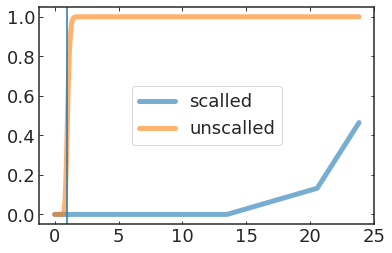

In [8]:
plt.plot(x, stats.f.cdf(x, 518, 111, x.mean(), np.ptp(x)), lw=5, alpha=0.6, label='scalled')
plt.plot(x, stats.f.cdf(x, 518, 111), lw=5, alpha=0.6, label='unscalled')
plt.axvline(1)
plt.legend()

In [9]:
#dofs=[x.splat_spectrum.toInstrument('WFC3-G141').dof for x in pectra ]

In [10]:
splat.initializeStandards()

In [11]:
spts=np.array([splat.typeToNum(x) for x in np.arange(16, 42)])

In [12]:
#remove object from forbidden list
splat_db0=splat.searchLibrary(vlm=True, giant=False, young=False)
splat_db0['SHORTNAME']=splat_db0.DESIGNATION.apply(splat.designationToShortName)
splat_db=splat_db0[~splat_db0.SHORTNAME.isin(wisps.FORBIDDEN_LIST)].reset_index(drop=True)

In [13]:
df=splat_db[splat_db.SPEX_TYPE.isin(spts)]

In [14]:
splat_within_snr=df[df.MEDIAN_SNR.between(5, 200)]

In [15]:
import splat.database as splatdb

Could not import regions, which is required for some of the functionalities of this module.


In [16]:
#binary vetting
folder='/volumes/LaCie/wispsdata/data/'
bindf=pd.read_csv(folder+'/binaries.txt', names=['name', ' '], sep=',')

In [17]:
groups=splat_within_snr.sort_values('MEDIAN_SNR',ascending=False).groupby('SPEX_TYPE')

In [18]:
picks=[]
for g in groups:
    picks.append(g[1].nlargest(20,'MEDIAN_SNR'  ))

In [19]:
df_picks=pd.concat(picks)

In [20]:
#s=splat.getSpectrum(lucky=True)[0]
#s.toInstrument('WFC3') forget smoothing

In [21]:

def create_splat_source(filename):
    try:
        #create a wisps spectrum
        #retrieve splat spectrum

        splat_s=splat.getSpectrum(filename=filename)[0]
        #spt=splat.typeToNum(splat_s.spex_type)
        #splat_s.toInstrument('WFC3-G141')

        #create a source object
        s=wisps.Spectrum( 
                       wave=splat_s.wave.value, 
                       flux=splat_s.flux.value,
                      noise=splat_s.noise.value,
                    contam= np.ones_like(splat_s.noise.value))
        
        #put it on wisps resolution
        
        s._splat_spectrum=splat_s

        s.normalize()
        return s
    except:
        return 


In [22]:
import wisps

In [23]:
df_picks['spt']=df_picks.SPEX_TYPE.apply(wisps.make_spt_number)

In [24]:
df_picks=df_picks.sort_values(by='spt')

In [25]:
%%capture
spectra=df_picks.DATA_FILE.apply(create_splat_source)

In [26]:
spectra

1034    anon spectrum
1167    anon spectrum
178     anon spectrum
855     anon spectrum
1256    anon spectrum
            ...      
236     anon spectrum
317     anon spectrum
799     anon spectrum
1401    anon spectrum
428              None
Name: DATA_FILE, Length: 443, dtype: object

In [27]:
def plot_sp_sp(s, a, shortname):
    std=splat.STDS_DWARF_SPEX[splat.typeToNum(s.spectral_type[0])]
    std.normalize(waverange=[1.1, 1.7])
    mask2=np.logical_and(std.wave.value>0.8, std.wave.value<2.5)
    
    mask=np.logical_and(s.wave>0.8, s.wave<2.5)
    a.plot(s.wave[mask], s.flux[mask], label=shortname,linewidth=3)
    a.plot(std.wave.value[mask2], std.flux.value[mask2], linestyle='--', label='std', alpha=0.5)
    
    
    a.set_title("{} ".format(s.spectral_type ))
    a.legend()


In [28]:
(spectra.iloc[0])

anon spectrum

In [29]:
#for idx, s in enumerate(spectra.dropna().values):
#    s.normalize()
#    fig, ax=plt.subplots()
#    plot_sp_sp(s, ax, idx)
    
    
   

In [30]:
def make_wisps(splat_s):
    try:
        s=wisps.Spectrum(wave=splat_s.wave.value, 
                           flux=splat_s.flux.value,
                          noise=splat_s.noise.value,
                        contam= np.ones_like(splat_s.noise.value))
        s.dof=len(s.wave)
        return s
    except:
        return 


In [31]:
import glob
from astropy.io import ascii

In [32]:
ydwarfs_stds=pd.read_pickle('/volumes/LaCie/wispsdata/db/ystandards.pkl')

#get y dwarfs
def get_shortname(n):
        return splat.designationToShortName(n).replace('J', 'WISE')

schn='/Volumes/Lacie/schneider/*.txt'
schntb=pd.read_csv('/Volumes/Lacie/wispsdata/data/schneider2015.txt', 
                   delimiter=' ').drop(columns='Unnamed: 14')
schntb['shortname']=schntb.Name.apply(get_shortname)
spectra_schn=[]
for f in glob.glob(schn):
    d=ascii.read(f).to_pandas()
    shortname=(f.split('/')[-1]).split('.txt')[0]
    s=splat.Spectrum(wave=d.col1, 
                     flux=d.col2,
                     noise=d.col3, 
                     name=shortname)
    #measure snr 
    mask= np.logical_and(d.col1>1.0, d.col1<2.4)
    snr= (np.nanmedian(d.col2[mask]/d.col3[mask]))
    spectra_schn.append([s, snr])

In [33]:
ydwarfs_data=[make_wisps(x) for x in np.array(spectra_schn).flatten()]

In [34]:
ydwarfs_data =[x for  x in ydwarfs_data if x]

In [35]:
t9s=[make_wisps(x) for x in splat.getSpectrum(spt='T9.0')]
t8s=[make_wisps(x) for x in splat.getSpectrum(spt='T8.0')]
y0=[make_wisps(x ) for x in ydwarfs_stds.spec]
y1=[make_wisps(x) for x in ydwarfs_stds.spec]
#l3s=[make_wisps(x) for x in splat.getSpectrum(spt='L3.0', binary=False, vlm=True, young=False)]


Retrieving 2 files


Retrieving 14 files



In [36]:
extras=[x for x in np.concatenate([t9s, t8s, y0, y1])]
extras=[x for x in extras if x]

In [37]:
retain=np.append(spectra.dropna().values, extras)
retain=np.append(retain, ydwarfs_data)

In [46]:
dfsp=pd.DataFrame()
dfsp['spectra']=retain
dfsp['spt']= [x.spectral_type for x in retain]
dfsp['splat_spectra']=[x.splat_spectrum for x in retain]

In [47]:
import pickle
with open(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl', 'wb') as file:
    pickle.dump(retain,file)

In [69]:
#create another file with just spectra interpolated
df_spectra_only=pd.DataFrame()
df_spectra_only['spt']= [x.spectral_type for x in retain]
df_spectra_only['flux']= [x.splat_spectrum.flux.value for  x in retain]
df_spectra_only['wave']=[x.splat_spectrum.wave.value for  x in retain]
df_spectra_only['noise']=[x.splat_spectrum.noise.value for  x in retain]

In [71]:
df_spectra_only.to_hdf('/volumes/LaCie/popsimsdata/spectral_templates_data.h5', key='singles')

[(0.0, 11.0)]

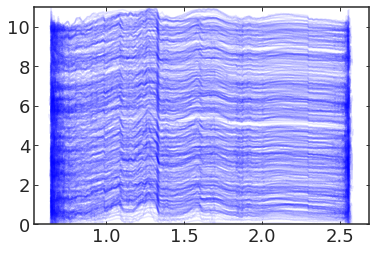

In [72]:
#visualize spectra
fig, ax=plt.subplots()
for x in dfsp['splat_spectra'].values:
    s.normalize()
    plt.plot(x.wave, x.flux.value+np.random.random()*10, c='b', alpha=0.1)

ax.set(ylim=[0, 11])

In [48]:
len(dfsp)

478

In [42]:
hgjbknl

NameError: name 'hgjbknl' is not defined

In [ ]:
rdpck=pd.read_pickle(wisps.OUTPUT_FILES+'/l_t_dwarfs_spex.pkl')

In [ ]:
bindf['shortname']=bindf.name.apply(str).apply(splat.designationToShortName)

In [ ]:
splat_within_snr['shortname']=splat_within_snr.DESIGNATION.apply(splat.designationToShortName)

In [ ]:
bsample=splat_within_snr[ ~ (splat_within_snr.shortname.isin(bindf.shortname) |
                             np.isnan(splat_db['PARALLAX']) | (splat_within_snr['SBINARY'] =='Y'))]

In [ ]:
bsample=bsample.reset_index(drop=True)

In [ ]:
%%capture
bsample_spectra=bsample.DATA_FILE.apply(create_splat_source)

In [ ]:
bsample['spectra']=bsample_spectra

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

In [ ]:
bsample=bsample.drop_duplicates(subset='shortname').reset_index(drop=True)

In [ ]:
dfextr=pd.DataFrame()
#dfextr['NAME']=['J045853.90+643451.9', 'WISE1738+2732', 'WISE1738+2732']
dfextr['SPEX_TYPE']=[x.spectral_type for x in extras]
#dfextr['shortname']=['J045853.90+643451.9', 'WISE1738+2732', 'WISE1738+2732']
dfextr['spectra']=extras


In [ ]:
#add T9 and y dwarfs
#dfextr
bspl=bsample.append(dfextr, ignore_index=True, verify_integrity=True, sort=True)

In [ ]:
bspl=bspl[~bspl.spectra.isna()]

In [ ]:
%%capture
with PdfPages(wisps.OUTPUT_FIGURES+'/multipage_binaries.pdf') as pdf:
    
    for g in np.array_split(bspl, int(len(bspl)/4)):
        fig, ax=plt.subplots(ncols=2, nrows=2)
        
        plot_sp_sp(g.spectra.iloc[0], ax[0][0], g.shortname.iloc[0])
        plot_sp_sp(g.spectra.iloc[1], ax[0][1],  g.shortname.iloc[1])
        plot_sp_sp(g.spectra.iloc[2], ax[1][0],  g.shortname.iloc[2])
        plot_sp_sp(g.spectra.iloc[3], ax[1][1],  g.shortname.iloc[3])

        pdf.savefig() 
        plt.close()

In [ ]:
bspl.reset_index(drop=True).to_pickle(wisps.OUTPUT_FILES+'/binary_spex.pkl')

In [ ]:
(bspl[['SOURCE_KEY', 'NAME', 'DESIGNATION', 'RA', 'DEC', 'DISCOVERY_REFERENCE',
       'OPT_TYPE', 'NIR_TYPE', 'LIT_TYPE',
       'J_2MASS',
       'H_2MASS_E', 'GRAVITY_CLASS_NIR','BINARY', 'SBINARY','SIMBAD_NAME', 'SIMBAD_SPT',
       'SIMBAD_SPT_REF', 'PARALLAX', 'PARALLAX_E', 'DISTANCE',
       'SPEX_GRAVITY_CLASSIFICATION', 
       'shortname']]).to_excel(wisps.OUTPUT_FILES+"/nonbinaries.xlsx")  